### Code to find the events of 0855-0714 and then find the probabilites of various mass uncertainties.

Note: you'll find the first part is a lot like the other demo. The main purpose of this is to show how the MCMC code works.

In [1]:
# add path to module so can import
import sys
sys.path = ['/users/judah/mlfinder'] + sys.path

# basic imports
from astropy.io import ascii
from astropy.table import Table

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import corner

# import module
from mlfinder.bd import BrownDwarf
from mlfinder.fields import Fields
from mlfinder.events import FindEvents
from mlfinder.mcmc import MonteCarlo

**Getting my brown dwarf data...**

In [2]:
# function to get only the number in a str (no +-). used in cell below
def number_only(string):
    string = str(string.replace(" ", ""))
    
    for i in range(len(string)):
        try:
            float(string)
            return string
        except:
            return number_only(string[:len(string) - 1])

In [3]:
candidate_stars = pd.read_csv('apjsaaf6aft4_ascii.txt', sep='\t')
candidate_stars = candidate_stars[['(1)', '(2)', '(3)', '(4)', '(5)', '(6)', '(8)', '(9)']]

# rename columns
candidate_stars.rename(columns = {'(1)':'object_name', '(2)':'ra', '(3)':'pm_ra', '(4)':'dec',
                                  '(5)':'pm_dec', '(6)':'pi', '(8)':'mu_alpha', '(9)':'mu_delta'}, 
                                  inplace=True)

# make pi and mu columns into pm_pi and pm_mu columns
pm_pi = [i.split()[2] for i in candidate_stars.pi]
pm_mu_a = [i.split()[2] for i in candidate_stars.mu_alpha]
pm_mu_d = [i.split()[2] for i in candidate_stars.mu_delta]

candidate_stars['pm_pi'] = pm_pi
candidate_stars['pm_mu_alpha'] = pm_mu_a
candidate_stars['pm_mu_delta'] = pm_mu_d

brown_dwarf = pd.DataFrame(candidate_stars.iloc[list(candidate_stars['object_name']).index('WISE 0855-0714'), :]).T

# grab only numbers (complicated to get value because brown dwarf is subsection of candidate_stars)
brown_dwarf['pi'] = number_only(brown_dwarf['pi'].values[0])
brown_dwarf['mu_alpha'] = number_only(brown_dwarf['mu_alpha'].values[0])
brown_dwarf['mu_delta'] = number_only(brown_dwarf['mu_delta'].values[0])

brown_dwarf.columns.values

array(['object_name', 'ra', 'pm_ra', 'dec', 'pm_dec', 'pi', 'mu_alpha',
       'mu_delta', 'pm_pi', 'pm_mu_alpha', 'pm_mu_delta'], dtype=object)

**Creating the brown dwarf class, fields class, and getting the events.**

In [4]:
bd = BrownDwarf(brown_dwarf)

bd_path = bd.find_path(start='2020-Jan-01', end='2030-Jan-01', step='3months')

In [5]:
stars = Fields(bd=bd, file=r'C:\Users\judah\candidate_stars_background\dr8\0855-0714_bs.txt')

In [6]:
events = FindEvents(bd, stars, 5)

events.event_table

,decals_id,ra,dec,dered_mag_r,gaia_pointsource,time,bd_ra,bd_dec,sep,delta_ml
0,7.696600e+15,-0.001426,0.000926,22.0466,0.0,2020.748802,-0.001603,0.000150,2.864957,167.892884
1,7.696600e+15,-0.015178,0.001579,20.9807,0.0,2026.747433,-0.015240,0.001282,1.090253,63.891282


**Just to prove to ourselves that it's working so far, lets look at the brown dwarf path.**

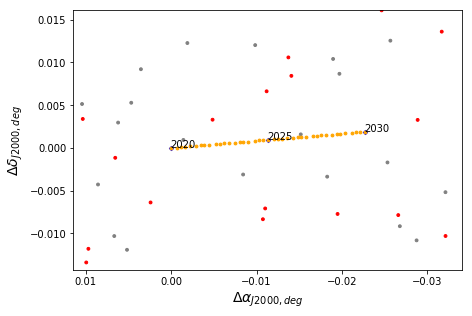

In [7]:
event_path_fig = events.plot_event_path(zoom=0.5, gaia_check=True, legend=False, point_size=8, font_size=10, figsize=None, label_size=14, years=5)

**Now for the MCMC stuff:**

In [8]:
# create a MonteCarlo instance and then sample/vary all the data a number of times
mc_all = events.event_mcmc(vary=['ra', 'dec', 'pi', 'mu_alpha', 'mu_delta'], which=1, samples=1000)

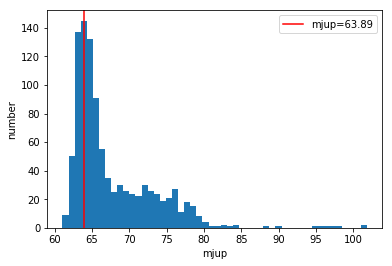

In [18]:
# plot these results in a histogram
plt.hist(mc_all, bins=50)

# add a verticle line to show what we measured
plt.axvline(events.event_table.iloc[1].delta_ml, color='red', label='mjup=63.89')

plt.ylabel('number')
plt.xlabel('mjup')
plt.legend()

In [19]:
# now make a corner plot. this will require me to create an instance of MonteCarlo for each variable I'm varying.
mc_ra = events.event_mcmc(vary=['ra'], which=1, samples=1000)

mc_dec = events.event_mcmc(vary=['dec'], which=1, samples=1000)

mc_pi = events.event_mcmc(vary=['pi'], which=1, samples=1000)

mc_mu_alpha = events.event_mcmc(vary=['mu_alpha'], which=1, samples=1000)

mc_mu_delta = events.event_mcmc(vary=['mu_delta'], which=1, samples=1000)

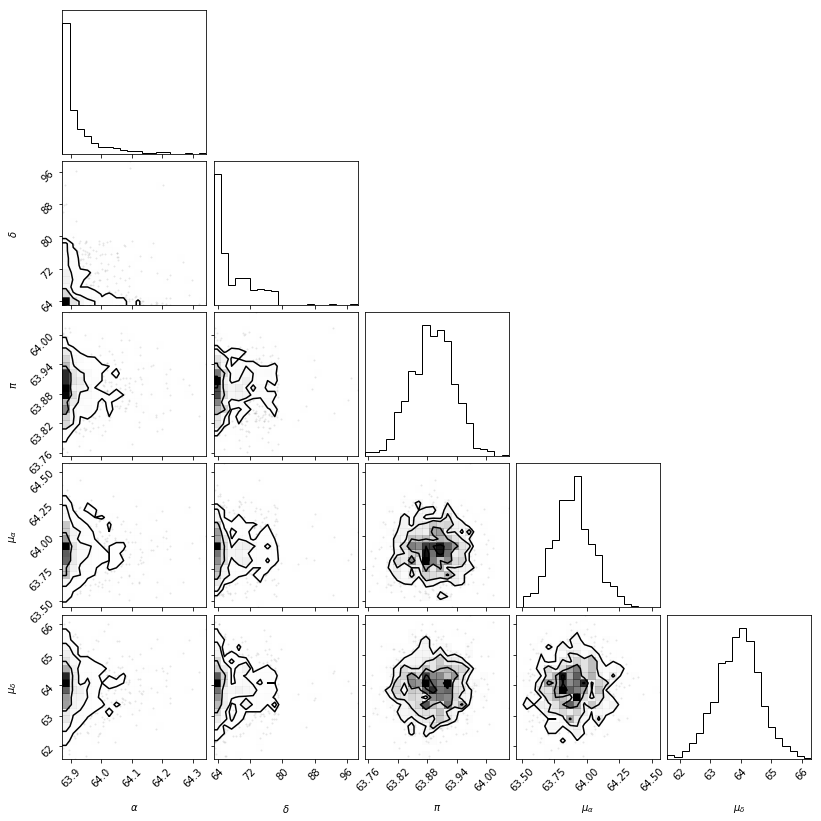

In [21]:
array = np.column_stack((mc_ra, mc_dec, mc_pi, mc_mu_alpha, mc_mu_delta))
plot = corner.corner(array, labels=[r'$\alpha$', r'$\delta$', r'$\pi$', r'$\mu_{\alpha}$', r'$\mu_{\delta}$'])